In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"grizzy","key":"b2d9b465f8be64190ce34f5bbc2a2d9f"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                          title                                           size  lastUpdated          downloadCount  
-----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
alexgude/california-traffic-collision-data-from-switrs       California Traffic Collision Data from SWITRS    1GB  2020-11-22 16:51:55            547  
babyoda/women-entrepreneurship-and-labor-force               Women Entrepreneurship and Labor Force           1KB  2020-11-21 08:38:51           1686  
szymonjanowski/internet-articles-data-with-users-engagement  Internet news data with readers engagement       3MB  2020-11-21 17:09:57            727  
sakshigoyal7/credit-card-customers                           Credit Card customers                          379KB  2020-11-19 07:38:44           3141  
imoore/2020-us-general-elect

In [4]:
! kaggle datasets download -d grouplens/movielens-20m-dataset

movielens-20m-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
! unzip movielens-20m-dataset.zip

Archive:  movielens-20m-dataset.zip
replace genome_scores.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace genome_tags.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace link.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace movie.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace rating.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace tag.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [6]:
import pandas as pd
import numpy as np
from sortedcontainers import SortedList

**USER BASED COLLABORATIVE FILTERING**

In [7]:
movie_df = pd.read_csv('movie.csv')

In [8]:
movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Create a new column titled year that extracts the year value from the title column, then remove the year from the title column.

In [9]:
movie_df['year'] = movie_df.title.apply(lambda x:x.split(' ')[-1][1:-1])

In [10]:
movie_df.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


Remove the year from the title column.

In [11]:
movie_df.title = movie_df.title.apply(lambda x:x.split('(')[0][:-1])

In [12]:
movie_df.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [13]:
ratings_df = pd.read_csv('rating.csv').drop('timestamp', axis=1)

In [14]:
ratings_df.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


Create a new dataframe that has the ratings and movie data merged (inner join), in order to easily see information.

In [15]:
movie_user_df = pd.merge(ratings_df, movie_df, on='movieId', how='left')

In [16]:
movie_user_df.head()

,userId,movieId,rating,title,genres,year
0,1,2,3.5,Jumanji,Adventure|Children|Fantasy,1995
1,1,29,3.5,"City of Lost Children, The",Adventure|Drama|Fantasy|Mystery|Sci-Fi,1995
2,1,32,3.5,Twelve Monkeys,Mystery|Sci-Fi|Thriller,1995
3,1,47,3.5,Seven,Mystery|Thriller,1995
4,1,50,3.5,"Usual Suspects, The",Crime|Mystery|Thriller,1995


In [17]:
movie_user_df['userId'].value_counts()

118205    9254
8405      7515
82418     5646
121535    5520
125794    5491
          ... 
59390       20
23558       20
34668       20
80291       20
58028       20
Name: userId, Length: 138493, dtype: int64

In [18]:
movie_user_df['movieId'].value_counts()

296       67310
356       66172
318       63366
593       63299
480       59715
          ...  
123607        1
90823         1
123609        1
123613        1
131136        1
Name: movieId, Length: 26744, dtype: int64

In [19]:
movie_user_df.isnull().values.any()

False

In [20]:
del movie_df
del ratings_df

In [21]:
len(movie_user_df)

20000263

Set the number of top users to keep. Then create a value_count series that will house the user Id associated with the top n numbers of users.

In [22]:
num_users_to_keep = 200

In [23]:
value_count_users = movie_user_df['userId'].value_counts().iloc[:num_users_to_keep]

In [24]:
value_count_users

118205    9254
8405      7515
82418     5646
121535    5520
125794    5491
          ... 
130622    2165
10761     2164
54113     2161
110706    2159
91349     2159
Name: userId, Length: 200, dtype: int64

In [25]:
value_count_users.sum()

580256

In [26]:
value_count_users.keys()

Int64Index([118205,   8405,  82418, 121535, 125794,  74142,  34576, 131904,
             83090,  59477,
            ...
               156,  21861,  66810, 137686,  18628, 130622,  10761,  54113,
            110706,  91349],
           dtype='int64', length=200)

Set the number of movies to keep. Then create a value_count series that will house the movie Id associated with the top n numbers of movies.

In [27]:
num_movies_to_keep = 1000

In [28]:
value_count_movies = movie_user_df['movieId'].value_counts().iloc[:num_movies_to_keep]

In [29]:
value_count_movies

296      67310
356      66172
318      63366
593      63299
480      59715
         ...  
1589      5044
1049      5039
915       5029
38061     5026
383       5025
Name: movieId, Length: 1000, dtype: int64

In [30]:
value_count_movies.keys()

Int64Index([  296,   356,   318,   593,   480,   260,   110,   589,  2571,
              527,
            ...
             5015, 55765,  2528,  3683, 52973,  1589,  1049,   915, 38061,
              383],
           dtype='int64', length=1000)

In [31]:
movie_user_df = movie_user_df[(movie_user_df['userId'].isin(value_count_users.keys())) & (movie_user_df['movieId'].isin(value_count_movies.keys()))]

In [32]:
movie_user_df

,userId,movieId,rating,title,genres,year
19846,156,1,5.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
19847,156,2,5.0,Jumanji,Adventure|Children|Fantasy,1995
19848,156,3,2.0,Grumpier Old Men,Comedy|Romance,1995
19850,156,5,3.0,Father of the Bride Part II,Comedy,1995
19851,156,6,4.0,Heat,Action|Crime|Thriller,1995
...,...,...,...,...,...,...
19963231,138208,78499,4.0,Toy Story 3,Adventure|Animation|Children|Comedy|Fantasy|IMAX,2010
19963237,138208,79132,3.0,Inception,Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX,2010
19963240,138208,80463,4.5,"Social Network, The",Drama,2010
19963248,138208,81591,3.5,Black Swan,Drama|Thriller,2010


In [33]:
from sklearn.utils import shuffle

In [34]:
split_ratio = 0.8
cutoff = int(split_ratio * len(movie_user_df))

Shuffle the dataset, then split the data into a train and test set.

In [35]:
movie_user_df = shuffle(movie_user_df)

In [36]:
movie_user_df

,userId,movieId,rating,title,genres,year
6752598,46470,8376,3.0,Napoleon Dynamite,Comedy,2004
10721269,74142,8641,3.0,Anchorman: The Legend of Ron Burgundy,Comedy,2004
9648213,66763,719,2.0,Multiplicity,Comedy,1996
18714770,129583,4027,4.5,"O Brother, Where Art Thou?",Adventure|Comedy|Crime,2000
19063221,131904,858,4.5,"Godfather, The",Crime|Drama,1972
...,...,...,...,...,...,...
3810841,25978,2699,2.5,Arachnophobia,Comedy|Horror,1990
4712392,32344,1721,3.5,Titanic,Drama|Romance,1997
10961406,75810,637,2.0,Sgt. Bilko,Comedy,1996
580996,3907,47,4.0,Seven,Mystery|Thriller,1995


Only keep columns and rows that have at least one non NaN value. Drop movies where all values are NaN.

In [37]:
movie_user_df.dropna(axis=0, how='all', inplace=True)

In [38]:
movie_user_df.dropna(axis=1, how='all', inplace=True)

In [39]:
movie_user_df_train = movie_user_df.iloc[:cutoff]
movie_user_df_test = movie_user_df.iloc[cutoff:]

In [40]:
movie_user_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117918 entries, 6752598 to 7419571
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   117918 non-null  int64  
 1   movieId  117918 non-null  int64  
 2   rating   117918 non-null  float64
 3   title    117918 non-null  object 
 4   genres   117918 non-null  object 
 5   year     117918 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 6.3+ MB


In [41]:
movie_user_df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29480 entries, 11458736 to 1328535
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   userId   29480 non-null  int64  
 1   movieId  29480 non-null  int64  
 2   rating   29480 non-null  float64
 3   title    29480 non-null  object 
 4   genres   29480 non-null  object 
 5   year     29480 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 1.6+ MB


Create the training set dataframe and the test set dataframe.

In [42]:
movie_user_pivot_df_train = movie_user_df_train.pivot_table(values='rating', index='userId', columns='movieId') 

In [43]:
movie_user_pivot_df_train

movieId,1,2,3,5,6,7,10,11,14,16,17,18,19,21,22,24,25,29,31,32,34,36,39,44,45,47,48,50,52,58,60,62,70,79,95,104,105,107,110,111,...,48774,48780,49272,49530,50872,51255,51662,52973,53125,53996,54001,54272,54286,54503,55765,55820,56174,56367,56782,58559,59315,60069,60684,63082,64614,68157,68358,68954,69122,69757,70286,71535,72998,73017,74458,78499,79132,80463,81591,81845
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
156,5.0,5.0,NaN,3.0,NaN,4.0,4.0,5.0,NaN,4.0,4.0,3.0,NaN,4.0,NaN,4.0,4.0,NaN,NaN,5.0,3.0,3.5,NaN,NaN,2.0,4.0,NaN,NaN,3.0,NaN,NaN,NaN,4.0,3.0,4.0,2.0,4.0,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
741,NaN,3.0,3.0,NaN,3.5,4.5,4.0,NaN,4.5,4.0,4.5,NaN,0.5,NaN,NaN,NaN,4.5,NaN,5.0,5.0,1.0,NaN,0.5,NaN,NaN,5.0,2.0,5.0,NaN,5.0,NaN,NaN,NaN,NaN,0.5,0.5,NaN,NaN,4.5,NaN,...,4.5,5.0,4.5,4.5,1.5,NaN,NaN,NaN,NaN,NaN,NaN,0.5,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903,4.0,4.0,NaN,NaN,NaN,3.0,1.0,3.0,3.0,3.0,NaN,NaN,1.0,4.0,2.0,2.0,4.0,4.0,NaN,NaN,4.0,NaN,3.0,2.0,4.0,4.0,1.0,5.0,4.0,NaN,4.0,2.0,4.0,NaN,NaN,4.0,NaN,2.0,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
982,3.0,2.0,2.0,NaN,NaN,2.0,3.0,NaN,3.0,4.0,3.0,NaN,NaN,3.0,3.0,NaN,3.5,4.0,3.0,NaN,2.5,3.0,3.0,1.5,NaN,5.0,2.5,NaN,3.0,NaN,NaN,NaN,3.5,2.5,2.5,3.0,3.0,NaN,3.0,4.0,...,4.0,3.0,3.5,3.0,NaN,NaN,3.5,NaN,2.5,3.5,NaN,3.5,3.5,3.5,NaN,4.5,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN
2261,3.0,3.5,2.5,1.0,NaN,1.5,3.0,4.5,3.0,3.0,NaN,2.0,1.5,NaN,3.5,3.0,3.0,NaN,2.5,NaN,4.0,2.5,3.0,NaN,2.5,4.0,NaN,3.5,4.0,NaN,NaN,2.5,NaN,NaN,3.0,1.5,3.0,NaN,NaN,3.5,...,1.5,NaN,2.5,2.5,NaN,NaN,2.5,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,3.0,1.5,3.0,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136268,NaN,2.0,2.0,NaN,5.0,3.0,3.0,NaN,4.0,NaN,NaN,NaN,1.0,3.0,2.0,NaN,4.0,3.0,4.0,NaN,4.0,4.0,3.0,2.0,3.0,NaN,3.0,4.0,3.0,5.0,2.5,NaN,NaN,2.0,3.0,2.0,3.0,NaN,NaN,4.0,...,3.0,4.0,3.0,4.0,3.0,2.0,1.5,3.0,3.0,NaN,2.5,2.0,3.0,NaN,3.5,NaN,NaN,3.5,2.0,4.0,3.5,3.0,2.0,2.5,NaN,3.0,3.5,3.5,1.5,NaN,NaN,3.0,4.0,3.0,NaN,3.5,3.5,3.5,3.5,3.5
137202,4.5,2.5,NaN,NaN,3.0,3.0,4.0,3.0,NaN,4.0,4.5,NaN,3.0,NaN,NaN,NaN,4.0,4.5,NaN,4.0,4.5,4.5,5.0,NaN,3.5,4.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,3.0,3.0,2.0,NaN,4.0,NaN,...,4.5,4.0,4.0,4.0,3.5,4.5,3.5,4.0,4.0,3.5,4.5,4.5,3.5,4.0,4.0,4.0,3.5,NaN,4.0,NaN,NaN,4.5,NaN,NaN,4.0,NaN,NaN,4.0,4.0,4.0,4.5,4.0,NaN,4.0,4.0,4.5,4.0,4.5,NaN,4.5
137277,4.0,NaN,3.0,3.0,4.0,3.0,3.0,3.0,NaN,3.5,NaN,NaN,2.5,NaN,3.0,NaN,3.5,NaN,NaN,4.5,4.0,NaN,NaN,1.5,NaN,4.5,NaN,4.5,NaN,4.0,NaN,NaN,3.5,NaN,NaN,3.0,3.5,NaN,3.5,4.0,...,5.0,4.0,NaN,3.5,4.0,4.0,3.0,3.5,2.5,NaN,3.0,3.0,4.0,3.5,NaN,4.0,NaN,4.0,NaN,4.0,3.5,4.5,4.0,4.0,NaN,4.5,3.5,4.0,NaN,3.5,NaN,3.5,NaN,3.5,4.0,NaN,4.0,4.0,4.0,3.5


In [44]:
movie_user_pivot_df_test = movie_user_df_test.pivot_table(values='rating', index='userId', columns='movieId') 

In [45]:
movie_user_pivot_df_test

movieId,1,2,3,5,6,7,10,11,14,16,17,18,19,21,22,24,25,29,31,32,34,36,39,44,45,47,48,50,52,58,60,62,70,79,95,104,105,107,110,111,...,48774,48780,49272,49530,50872,51255,51662,52973,53125,53996,54001,54272,54286,54503,55765,55820,56174,56367,56782,58559,59315,60069,60684,63082,64614,68157,68358,68954,69122,69757,70286,71535,72998,73017,74458,78499,79132,80463,81591,81845
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
156,NaN,NaN,2.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
741,5.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.5,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903,NaN,NaN,2.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
982,NaN,NaN,NaN,2.5,3.5,NaN,NaN,3.0,NaN,NaN,NaN,4.0,3.0,NaN,NaN,2.5,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2261,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,2.5,NaN,NaN,3.5,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136268,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,5.0,5.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,3.0,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
137202,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.5,3.5,NaN,4.0,4.5,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN
137277,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,2.5,NaN,4.5,NaN,3.5,NaN,NaN,5.0,NaN,NaN,NaN,NaN


In [46]:
del movie_user_df

In [47]:
test_val = movie_user_pivot_df_train.iloc[0][2]
test_val

5.0

In [48]:
np.isnan(test_val)

False

In [49]:
def update_dictionaries(dataframe):
    """This function takes in the pivot table dataframe and creates 3 dictionaries:
       1) user2movie: This dictionary has user Ids as the keys and returns a list of 
                      movies this user has rated
       2) movie2user: This dictionary has movieIds as the keys and returns a list of 
                      users that have rated the movie
       3) usermovie2rating: This dictionary takes a tuple value of userId and movieId
                            and returns the rating given by a certain user on a specific
                            movie
       The function will return these dictionaries and is easily usable for any dataframe that
       has been constructed in a manner that has user ids as the rows and movie ids as the 
       columns. It avoids the NaN values in dataframe cells. """

    user2movie = {}
    movie2user = {}
    usermovie2rating = {}
    for i, j in dataframe.iterrows(): 
      for movie_id, rating in j.items():
          if np.isnan(rating) == False:
              if (i not in user2movie):
                  user2movie[i] = [movie_id]
              else:
                  user2movie[i].append(movie_id)
                  
              if (movie_id not in movie2user):
                  movie2user[movie_id] = [i]
              else:
                  movie2user[movie_id].append(i)

              usermovie2rating[(i,movie_id)] = rating

    return user2movie, movie2user, usermovie2rating

Create the dictionaries for the training set containing pertinent information for quick lookups of desired values.

In [50]:
user2movie_train, movie2user_train, usermovie2rating_train = update_dictionaries(movie_user_pivot_df_train)

Sanity check shown below. 

In [51]:
list(user2movie_train.keys())[0]

156

In [52]:
print(movie_user_pivot_df_train.iloc[0].value_counts().sum() == len(user2movie_train[list(user2movie_train.keys())[0]]))
print(movie_user_pivot_df_train[1].value_counts().sum() == len(movie2user_train[1]))

True
True


In [53]:
user2movie_test, movie2user_test, usermovie2rating_test = update_dictionaries(movie_user_pivot_df_test)

In [54]:
print(movie_user_pivot_df_test.iloc[0].value_counts().sum() == len(user2movie_test[list(user2movie_test.keys())[0]]))
print(movie_user_pivot_df_test[1].value_counts().sum() == len(movie2user_test[1]))

True
True


In [55]:
num_neighbors = 25
limit = 5
averages_dict = {}
deviations_dict = {}
neighbors_dict = {}

In [56]:
i = 0
for user_id in list(user2movie_train.keys()):
    movies_for_user_id = user2movie_train[user_id]
    movies_user_id_set = set(movies_for_user_id) # set will be used for common movies with other users
    # Create a user specific ratings dictionary containing the movie id as the key and the ratings associated with
    # the specific user in order to calculate the average rating given by a specific user and ultimately 
    # allow for the calculation of deviations for the user
    ratings_user_id = {movie_id:usermovie2rating_train[(user_id, movie_id)] for movie_id in movies_for_user_id}
    average_user_id = np.mean(list(ratings_user_id.values())) # calculate the average rating of the user
    averages_dict[user_id] = average_user_id
    deviations_user_id = {movie_id:(rating - average_user_id) for movie_id, rating in ratings_user_id.items()} # calculate the deviation of each rating relative to the average for the user
    values_deviations_user_id = np.array(list(deviations_user_id.values()))
    deviations_dict[user_id] = deviations_user_id # deviations dictionary with key as user id and values as deviations by movie id for access in prediction function
    sigma_user_id = np.sqrt(values_deviations_user_id.dot(values_deviations_user_id)) # calculation for the denominator of the Pearson Correlation formula
    sorted_list_corr = SortedList() # keep a sorted list for the weights to be calculated below
    for user_id_j in list(user2movie_train.keys()):
        if user_id_j != user_id:
            movies_for_user_id_j = user2movie_train[user_id_j]
            movies_user_id_j_set = set(movies_for_user_id_j) # set will be used for common movies with other users
            movies_in_common = (movies_user_id_set & movies_user_id_j_set) # intersection of the two users in regards to movies rated
            # only calculate the values on user j if the two users have greater than or equal to the same number of movies in common
            if len(movies_in_common) >= limit:
                ratings_user_id_j = {movie_id:usermovie2rating_train[(user_id_j, movie_id)] for movie_id in movies_for_user_id_j}
                average_user_id_j = np.mean(list(ratings_user_id_j.values()))
                deviations_user_id_j = {movie_id:(rating - average_user_id_j) for movie_id, rating in ratings_user_id_j.items()}
                values_deviations_user_id_j = np.array(list(deviations_user_id_j.values()))
                sigma_user_id_j = np.sqrt(values_deviations_user_id_j.dot(values_deviations_user_id_j)) # calculation for the denominator of the Pearson Correlation formula

                # now, calculate the pearson correlation coefficient for similarity between the users
                pc_numerator = sum(deviations_user_id[id] * deviations_user_id_j[id] for id in movies_in_common)
                weight_ij = pc_numerator/(sigma_user_id * sigma_user_id_j)
                sorted_list_corr.add((-weight_ij, user_id_j)) # add a weight and user id j tuple into the sorted list
                if len(sorted_list_corr) > num_neighbors:
                    del sorted_list_corr[-1] # if the sorted list has more than the number of neighbors desired, delete lowest correlation value
    
    neighbors_dict[user_id] = sorted_list_corr
    #neighbors_list.append(sorted_list_corr)
    i+=1
    if i % 10 == 0:
        print(i)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200


In [57]:
list(neighbors_dict.items())[10]

(7201,
 SortedList([(-0.2907535540780744, 8405), (-0.28021103974826217, 18138), (-0.25712119856148064, 92956), (-0.2558172357902425, 116189), (-0.2439293233322659, 26193), (-0.22556662198263963, 137277), (-0.22401931706480113, 119048), (-0.22225503385996412, 23173), (-0.22060905390677404, 79159), (-0.21962582068655515, 75810), (-0.21923530483367373, 54107), (-0.21841848525026505, 53346), (-0.2164827944650042, 22901), (-0.21488713731106854, 88820), (-0.214156457931983, 42204), (-0.21373702570730857, 25101), (-0.2127780016194191, 100134), (-0.2067391995456139, 131961), (-0.20419124089176682, 123606), (-0.2037971670950214, 27469), (-0.2028789238588281, 75299), (-0.2021796419472317, 15478), (-0.20213776467608877, 137202), (-0.20161433379572538, 135425), (-0.20153108588911367, 903)]))

In [58]:
def predict_rating(user_id, movie_id):
    """Function used to predict the rating when given a specific user_id and movie_id,
       based upon the correlation of the top number of neighbors associated with the user."""
    num = 0
    denom = 0
    for negative_weight, user_id_j in neighbors_dict[user_id]:
        try:
            # Use the positive weight value associated with the neighbor and multiply by the deviation of the neighbor with
            # regards to how they rated the movie.
            num += -negative_weight * deviations_dict[user_id_j][movie_id] 
            denom += abs(negative_weight)
        except KeyError:
            # If the neighbor has not rated the movie, simply pass on the addition of the weighted average for 
            # that movie.
            pass
        
    if denom == 0:
        # if the neighbors have not rated any of the movies in question, simply use the user in questions
        # average rating as the overall prediction.
        prediction = averages_dict[user_id]
    else:
        prediction = num/denom + averages_dict[user_id]
    prediction = max(0.5, min(5, prediction)) # bounded rating from 0.5 to 5
    return prediction    

In [59]:
train_preds = []
train_targets = []
test_preds = []
test_targets = []

for (user_id, movie_id), target in usermovie2rating_train.items():
    pred = predict_rating(user_id, movie_id)
    train_preds.append(pred)
    train_targets.append(target)

for (user_id, movie_id), target in usermovie2rating_test.items():
    pred = predict_rating(user_id, movie_id)
    test_preds.append(pred)
    test_targets.append(target)


In [60]:
def calculate_mse(preds, targets):
    preds = np.array(preds)
    targets = np.array(targets)
    return np.mean((preds - targets) ** 2)

In [61]:
print('Train_MSE: ', calculate_mse(train_preds, train_targets))
print('Test_MSE: ', calculate_mse(test_preds, test_targets))

Train_MSE:  0.602334392146921
Test_MSE:  0.6246228222374697


**ITEM-ITEM COLLABORATIVE FILTERING**

This section of code was derived from the user-user based collaborative filtering above with the dataset flipped in a manner in which movie indeces were the rows and users were the columns in order to give item-item filtering.

In [62]:
movie_df = pd.read_csv('movie.csv')

In [63]:
movie_df['year'] = movie_df.title.apply(lambda x:x.split(' ')[-1][1:-1])
movie_df.title = movie_df.title.apply(lambda x:x.split('(')[0][:-1])
movie_df.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [64]:
ratings_df = pd.read_csv('rating.csv').drop('timestamp', axis=1)
ratings_df.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [65]:
movie_user_df = pd.merge(movie_df, ratings_df, on='movieId', how='left')
movie_user_df.head()

,movieId,title,genres,year,userId,rating
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,3.0,4.0
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,6.0,5.0
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,8.0,4.0
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,10.0,4.0
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,11.0,4.5


In [66]:
movie_user_df['userId'].value_counts()

118205.0    9254
8405.0      7515
82418.0     5646
121535.0    5520
125794.0    5491
            ... 
96117.0       20
79785.0       20
3937.0        20
53181.0       20
102028.0      20
Name: userId, Length: 138493, dtype: int64

In [67]:
movie_user_df['movieId'].value_counts()

296       67310
356       66172
318       63366
593       63299
480       59715
          ...  
123385        1
106992        1
106996        1
90514         1
131136        1
Name: movieId, Length: 27278, dtype: int64

In [68]:
del movie_df
del ratings_df

In [69]:
num_movies_to_keep = 1000
value_count_movies = movie_user_df['movieId'].value_counts().iloc[:num_movies_to_keep]
value_count_movies

296      67310
356      66172
318      63366
593      63299
480      59715
         ...  
1589      5044
1049      5039
915       5029
38061     5026
383       5025
Name: movieId, Length: 1000, dtype: int64

In [70]:
num_users_to_keep = 200
value_count_users = movie_user_df['userId'].value_counts().iloc[:num_users_to_keep]
value_count_users

118205.0    9254
8405.0      7515
82418.0     5646
121535.0    5520
125794.0    5491
            ... 
130622.0    2165
10761.0     2164
54113.0     2161
110706.0    2159
91349.0     2159
Name: userId, Length: 200, dtype: int64

In [71]:
movie_user_df = movie_user_df[(movie_user_df['userId'].isin(value_count_users.keys())) & (movie_user_df['movieId'].isin(value_count_movies.keys()))]

In [72]:
movie_user_df

,movieId,title,genres,year,userId,rating
56,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,156.0,5.0
258,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,741.0,5.0
319,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,903.0,4.0
340,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,982.0,3.0
817,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,2261.0,3.0
...,...,...,...,...,...,...
19612051,81845,"King's Speech, The",Drama,2010,134773.0,5.0
19612096,81845,"King's Speech, The",Drama,2010,136268.0,3.5
19612127,81845,"King's Speech, The",Drama,2010,137202.0,4.5
19612134,81845,"King's Speech, The",Drama,2010,137277.0,3.5


In [73]:
movie_user_df['movieId'].nunique()

1000

In [74]:
movie_user_df['userId'].nunique()

200

In [75]:
from sklearn.utils import shuffle

In [76]:
split_ratio = 0.8
cutoff = int(split_ratio * len(movie_user_df))

In [77]:
movie_user_df = shuffle(movie_user_df)

Convert the float userId value to an int.

In [78]:
movie_user_df['userId'] = movie_user_df.userId.apply(lambda x:int(x))
movie_user_df

,movieId,title,genres,year,userId,rating
12279429,2997,Being John Malkovich,Comedy|Drama|Fantasy,1999,37317,4.0
10809782,2470,Crocodile Dundee,Adventure|Comedy,1986,12131,2.5
6117738,1193,One Flew Over the Cuckoo's Nest,Drama,1975,89402,5.0
1821912,276,Milk Money,Comedy|Romance,1994,131961,2.0
17983258,33679,Mr. & Mrs. Smith,Action|Adventure|Comedy|Romance,2005,112988,4.0
...,...,...,...,...,...,...
3062997,454,"Firm, The",Drama|Thriller,1993,116361,3.5
13535704,3671,Blazing Saddles,Comedy|Western,1974,55765,4.0
13342010,3535,American Psycho,Crime|Horror|Mystery|Thriller,2000,104345,2.5
15530751,5266,Panic Room,Thriller,2002,982,3.0


In [79]:
movie_user_df.dropna(axis=0, how='all', inplace=True)
movie_user_df.dropna(axis=1, how='all', inplace=True)

In [80]:
movie_user_df_train = movie_user_df.iloc[:cutoff]
movie_user_df_test = movie_user_df.iloc[cutoff:]

In [81]:
movie_user_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117918 entries, 12279429 to 9682694
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   movieId  117918 non-null  int64  
 1   title    117918 non-null  object 
 2   genres   117918 non-null  object 
 3   year     117918 non-null  object 
 4   userId   117918 non-null  int64  
 5   rating   117918 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 6.3+ MB


In [82]:
movie_user_df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29480 entries, 7293484 to 10583783
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  29480 non-null  int64  
 1   title    29480 non-null  object 
 2   genres   29480 non-null  object 
 3   year     29480 non-null  object 
 4   userId   29480 non-null  int64  
 5   rating   29480 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 1.6+ MB


In [83]:
movie_user_pivot_df_train = movie_user_df_train.pivot_table(values='rating', columns='userId', index='movieId') 
movie_user_pivot_df_train

userId,156,741,903,982,2261,3318,3907,4222,4358,6719,7201,8405,8963,9034,9087,9544,10303,10761,12131,14705,15478,15486,15617,16676,17040,18138,18611,18628,20132,21163,21391,21398,21861,22901,23173,24219,24688,24830,25101,25978,...,113668,114406,116189,116317,116361,117144,118205,118754,119048,119531,120575,120948,121535,121930,122995,123352,123606,125794,125978,128258,128309,129583,130459,130622,130767,131347,131651,131894,131904,131961,133372,133811,134567,134773,135425,136268,137202,137277,137686,138208
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,5.0,4.0,3.0,3.0,4.5,4.0,NaN,5.0,NaN,NaN,5.0,NaN,NaN,5.0,3.0,NaN,NaN,NaN,3.5,NaN,2.0,NaN,5.0,4.0,4.0,4.0,5.0,5.0,NaN,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,NaN,...,3.0,5.0,3.5,4.5,4.0,5.0,NaN,4.5,5.0,4.0,NaN,4.5,3.0,3.5,5.0,NaN,4.0,NaN,NaN,4.0,4.0,4.5,NaN,3.0,4.5,5.0,2.0,5.0,3.0,4.0,5.0,5.0,4.0,5.0,3.0,4.0,4.5,4.0,5.0,3.0
2,NaN,3.0,4.0,2.0,NaN,3.0,2.5,NaN,3.0,4.0,1.0,3.0,NaN,NaN,1.0,NaN,4.0,5.0,NaN,2.0,NaN,2.5,NaN,2.0,NaN,NaN,3.0,4.0,NaN,NaN,NaN,4.0,2.5,2.0,2.0,3.5,3.0,3.5,2.0,3.0,...,4.0,1.0,NaN,3.5,NaN,2.5,NaN,2.5,2.5,NaN,2.5,3.0,3.0,2.5,3.0,NaN,NaN,4.0,NaN,4.0,1.0,3.5,3.5,3.0,NaN,2.5,NaN,NaN,3.0,2.0,3.0,5.0,4.0,NaN,NaN,2.0,NaN,2.5,3.0,2.0
3,2.0,3.0,2.0,NaN,NaN,3.0,NaN,3.5,1.0,NaN,NaN,2.5,NaN,NaN,NaN,2.0,3.0,NaN,1.0,2.0,1.0,NaN,NaN,NaN,NaN,2.0,1.0,2.0,4.0,NaN,NaN,NaN,NaN,2.0,NaN,4.0,3.0,3.0,2.5,4.0,...,NaN,NaN,3.0,1.0,NaN,3.5,3.0,NaN,3.0,3.0,3.5,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,3.5,NaN,NaN,NaN,3.5,NaN,NaN,NaN,1.0,2.0,3.5,4.5,3.0,NaN,2.0,NaN,3.0,3.0,2.0
5,3.0,4.0,3.0,2.5,1.0,2.5,NaN,NaN,NaN,3.5,NaN,1.5,NaN,NaN,3.5,NaN,3.0,NaN,2.0,1.0,NaN,3.0,NaN,NaN,NaN,2.0,1.0,NaN,5.0,2.0,NaN,NaN,NaN,NaN,2.0,3.5,NaN,NaN,NaN,3.5,...,2.5,NaN,1.5,3.0,NaN,NaN,3.0,2.0,NaN,3.0,3.0,3.5,2.5,NaN,NaN,3.5,NaN,3.5,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
6,4.0,3.5,4.0,3.5,3.5,3.0,4.0,NaN,5.0,5.0,2.0,NaN,3.5,2.0,3.0,4.0,5.0,3.0,3.5,NaN,3.0,2.5,3.5,NaN,NaN,4.0,4.0,4.0,NaN,NaN,4.0,NaN,2.0,5.0,4.5,4.5,4.0,5.0,5.0,3.5,...,NaN,3.0,4.0,NaN,4.5,2.0,4.0,5.0,NaN,3.0,NaN,NaN,5.0,3.0,NaN,4.0,NaN,5.0,2.0,NaN,NaN,NaN,3.5,5.0,4.0,4.5,3.0,NaN,3.5,NaN,NaN,5.0,3.5,3.0,NaN,NaN,NaN,4.0,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.5,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,4.0,4.0,3.5,NaN,NaN,NaN,4.0,NaN,NaN,NaN,5.0,NaN,4.0,4.0,NaN,NaN,3.5,...,NaN,2.5,NaN,4.0,4.0,NaN,4.5,NaN,4.5,NaN,NaN,5.0,4.0,NaN,4.0,NaN,NaN,4.5,NaN,3.0,NaN,4.0,NaN,NaN,3.5,5.0,NaN,NaN,3.5,NaN,NaN,5.0,3.5,4.5,NaN,3.5,4.5,5.0,NaN,4.0
79132,NaN,NaN,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,NaN,4.0,NaN,2.0,NaN,3.0,4.0,NaN,NaN,3.5,NaN,NaN,3.5,2.5,3.5,5.0,4.5,4.5,NaN,3.5,NaN,4.0,NaN,3.5,NaN,4.5,NaN,NaN,NaN,4.0,...,NaN,2.0,3.5,4.5,4.0,4.0,NaN,NaN,3.0,NaN,5.0,4.5,3.5,3.5,NaN,5.0,NaN,4.5,4.0,NaN,3.5,5.0,NaN,NaN,3.5,5.0,NaN,5.0,3.0,NaN,NaN,4.0,NaN,5.0,NaN,3.5,4.0,4.0,NaN,3.0
80463,NaN,NaN,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN,4.0,4.5,4.0,3.0,NaN,NaN,4.0,NaN,3.0,NaN,NaN,NaN,4.5,4.0,4.0,4.5,4.0,NaN,NaN,3.5,3.5,NaN,NaN,5.0,NaN,NaN,3.5,NaN,NaN,NaN,...,NaN,4.5,4.0,NaN,3.5,NaN,3.5,NaN,5.0,4.5,3.5,4.0,4.0,3.5,NaN,NaN,NaN,4.5,4.0,3.5,4.5,4.5,NaN,3.5,4.0,NaN,NaN,NaN,4.0,NaN,NaN,4.5,4.5,5.0,NaN,3.5,4.5,4.0,NaN,4.5


In [84]:
movie_user_pivot_df_test = movie_user_df_test.pivot_table(values='rating', columns='userId', index='movieId') 
movie_user_pivot_df_test

userId,156,741,903,982,2261,3318,3907,4222,4358,6719,7201,8405,8963,9034,9087,9544,10303,10761,12131,14705,15478,15486,15617,16676,17040,18138,18611,18628,20132,21163,21391,21398,21861,22901,23173,24219,24688,24830,25101,25978,...,113668,114406,116189,116317,116361,117144,118205,118754,119048,119531,120575,120948,121535,121930,122995,123352,123606,125794,125978,128258,128309,129583,130459,130622,130767,131347,131651,131894,131904,131961,133372,133811,134567,134773,135425,136268,137202,137277,137686,138208
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,4.0,4.5,NaN,2.5,NaN,NaN,NaN,4.0,4.0,3.0,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.5,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.0,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,2.5,NaN,NaN,1.5,NaN,NaN,3.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN
3,NaN,NaN,NaN,2.0,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,2.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.5,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,5.0,5.0,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,3.0,NaN,NaN,NaN,3.5,5.0,3.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78499,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,5.0,NaN,4.5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,4.5,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,4.5,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.5,NaN,NaN,3.5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
def update_dictionaries_item(dataframe):
    """This function takes in the pivot table dataframe and creates 3 dictionaries:
       1) user2movie: This dictionary has user Ids as the keys and returns a list of 
                      movies this user has rated
       2) movie2user: This dictionary has movieIds as the keys and returns a list of 
                      users that have rated the movie
       3) usermovie2rating: This dictionary takes a tuple value of userId and movieId
                            and returns the rating given by a certain user on a specific
                            movie
       The function will return these dictionaries and is easily usable for any dataframe that
       has been constructed in a manner that has user ids as the rows and movie ids as the 
       columns. It avoids the NaN values in dataframe cells. """

    user2movie = {}
    movie2user = {}
    usermovie2rating = {}
    for i, j in dataframe.iterrows(): 
      for user_id, rating in j.items():
          if np.isnan(rating) == False:
              if (user_id not in user2movie):
                  user2movie[user_id] = [i]
              else:
                  user2movie[user_id].append(i)
                  
              if (i not in movie2user):
                  movie2user[i] = [user_id]
              else:
                  movie2user[i].append(user_id)

              usermovie2rating[(user_id, i)] = rating

    return user2movie, movie2user, usermovie2rating

In [86]:
user2movie_train, movie2user_train, usermovie2rating_train = update_dictionaries_item(movie_user_pivot_df_train)
user2movie_test, movie2user_test, usermovie2rating_test = update_dictionaries_item(movie_user_pivot_df_test)

In [87]:
num_neighbors = 25
limit = 5
averages_dict = {}
deviations_dict = {}
neighbors_dict = {}

In [88]:
i = 0
for movie_id in list(movie2user_train.keys()):
    users_for_movie_id = movie2user_train[movie_id] # acquire the users who rated the movie
    users_movie_id_set = set(users_for_movie_id) # turn into a set in order to find intersection with other movies
    ratings_movie_id = {user_id:usermovie2rating_train[(user_id, movie_id)] for user_id in users_for_movie_id}
    average_movie_id = np.mean(list(ratings_movie_id.values()))
    averages_dict[movie_id] = average_movie_id # store the averages for a movie in a dictionary
    deviations_movie_id = {user_id:(rating - average_movie_id) for user_id, rating in ratings_movie_id.items()}
    values_deviations_movie_id = np.array(list(deviations_movie_id.values()))
    deviations_dict[movie_id] = deviations_movie_id # store the deviations associated with each movie in a dictionary
    sigma_movie_id = np.sqrt(values_deviations_movie_id.dot(values_deviations_movie_id))
    sorted_list_corr = SortedList()

    for movie_id_j in list(movie2user_train.keys()):
        if movie_id_j != movie_id:
            users_for_movie_id_j = movie2user_train[movie_id_j]
            users_movie_id_j_set = set(users_for_movie_id_j) 
            users_in_common = (users_movie_id_set & users_movie_id_j_set) # intersection of users for movies i and j

            if len(users_in_common) >= limit:
                ratings_movie_id_j = {user_id:usermovie2rating_train[(user_id, movie_id_j)] for user_id in users_for_movie_id_j}
                average_movie_id_j = np.mean(list(ratings_movie_id_j.values()))
                deviations_movie_id_j = {user_id:(rating - average_movie_id_j) for user_id, rating in ratings_movie_id_j.items()}
                values_deviations_movie_id_j = np.array(list(deviations_movie_id_j.values()))
                sigma_movie_id_j = np.sqrt(values_deviations_movie_id_j.dot(values_deviations_movie_id_j))
                # now, calculate the pearson correlation coefficient for similarity between the movies
                pc_numerator = sum(deviations_movie_id[id] * deviations_movie_id_j[id] for id in users_in_common)
                weight_ij = pc_numerator/(sigma_movie_id * sigma_movie_id_j)
                sorted_list_corr.add((-weight_ij, movie_id_j))
                if len(sorted_list_corr) > num_neighbors:
                    del sorted_list_corr[-1]
    neighbors_dict[movie_id] = sorted_list_corr

    if i % 10 == 0:
        print(i)
    i+=1      

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [89]:
list(neighbors_dict.items())[10]

(17,
 SortedList([(-0.4067023273105114, 515), (-0.3707762514932537, 838), (-0.3449739292514651, 150), (-0.34331275361656133, 1296), (-0.333589805702646, 1103), (-0.33198033803501964, 902), (-0.33145387200416154, 3408), (-0.33009227398246066, 232), (-0.3285705555915673, 3317), (-0.32672672712347056, 3072), (-0.31715714990799154, 1247), (-0.3163925404973662, 58), (-0.30724952646276305, 222), (-0.30628454255823695, 2355), (-0.3007090706600165, 25), (-0.2992757693593733, 953), (-0.29741739727705213, 590), (-0.29710904353298695, 1172), (-0.2947949475289666, 307), (-0.2907333818043009, 920), (-0.29012600908067226, 5945), (-0.2899394034416821, 6377), (-0.28814901775956486, 1104), (-0.28769464585362736, 4034), (-0.2835811442697507, 2108)]))

In [90]:
def predict_rating_item(user_id, movie_id):
    num = 0
    denom = 0
    for negative_weight, movie_id_j in neighbors_dict[movie_id]:
        try:
            # Use the positive weight value associated with the neighbor and multiply by the deviation of the neighbor with
            # regards to how the movie was rated by users
            num += -negative_weight * deviations_dict[movie_id_j][user_id] 
            denom += abs(negative_weight)
        except KeyError:
            # If the neighbor has not rated the movie, simply pass on the addition of the weighted average for 
            # that movie.
            pass
        
    if denom == 0:
        # if the neighbors have not rated any of the movies in question, simply use the movie in questions
        # average rating as the overall prediction.
        prediction = averages_dict[movie_id]
    else:
        prediction = num/denom + averages_dict[movie_id]
    prediction = max(0.5, min(5, prediction)) # bounded rating from 0.5 to 5
    return prediction

In [91]:
train_preds = []
train_targets = []
test_preds = []
test_targets = []

for (user_id, movie_id), target in usermovie2rating_train.items():
    pred = predict_rating_item(user_id, movie_id)
    train_preds.append(pred)
    train_targets.append(target)

for (user_id, movie_id), target in usermovie2rating_test.items():
    pred = predict_rating_item(user_id, movie_id)
    test_preds.append(pred)
    test_targets.append(target)

In [92]:
def calculate_mse(preds, targets):
    preds = np.array(preds)
    targets = np.array(targets)
    return np.mean((preds - targets) ** 2)

In [93]:
print('Train_MSE_Item: ', calculate_mse(train_preds, train_targets))
print('Test_MSE_Item: ', calculate_mse(test_preds, test_targets))

Train_MSE_Item:  0.3785041420809301
Test_MSE_Item:  0.5765269055567486


**Matrix Factorization**

In [94]:
user2movierating_train_mat = {}
movie2userrating_train_mat = {}

In [95]:
"""Create a dictionary that holds the user id as a key with the associated movie ids rated along with a numpy
   array of ratings values in order to be used for vectorized calculation."""
for user_id, movie_ids in user2movie_train.items():
    ratings_user_id = np.array([usermovie2rating_train[(user_id, movie)] for movie in movie_ids]) 
    user2movierating_train_mat[user_id] = (movie_ids, ratings_user_id)

"""Create a dictionary that holds the movie id as a key with the associated users who rated along with a numpy
   array of ratings values in order to be used for vectorized calculation."""
for movie_id, user_ids in movie2user_train.items():
    ratings_movie_id = np.array([usermovie2rating_train[(user, movie_id)] for user in user_ids]) 
    movie2userrating_train_mat[movie_id] = (user_ids, ratings_movie_id)

In [96]:
len(list(user2movierating_train_mat.items())[0][1][0]) == len(list(user2movierating_train_mat.items())[0][1][1])

True

In [98]:
len(list(movie2userrating_train_mat.items())[0][1][0]) == len(list(movie2userrating_train_mat.items())[0][1][1])

True

In [99]:
list(user2movierating_train_mat.items())[0]

(741,
 ([1,
   2,
   3,
   5,
   6,
   7,
   10,
   14,
   19,
   21,
   22,
   25,
   31,
   32,
   34,
   39,
   47,
   48,
   50,
   58,
   70,
   95,
   104,
   105,
   110,
   112,
   141,
   150,
   151,
   153,
   158,
   161,
   163,
   168,
   185,
   193,
   196,
   223,
   224,
   231,
   235,
   253,
   260,
   261,
   272,
   273,
   282,
   288,
   292,
   293,
   296,
   300,
   315,
   316,
   317,
   329,
   337,
   339,
   344,
   349,
   353,
   355,
   356,
   364,
   367,
   370,
   372,
   380,
   382,
   410,
   413,
   420,
   431,
   432,
   434,
   435,
   440,
   442,
   454,
   455,
   457,
   468,
   474,
   475,
   480,
   481,
   485,
   494,
   497,
   500,
   509,
   515,
   520,
   527,
   529,
   535,
   539,
   541,
   546,
   551,
   553,
   585,
   586,
   587,
   588,
   589,
   590,
   592,
   593,
   594,
   595,
   597,
   608,
   653,
   708,
   733,
   736,
   750,
   778,
   780,
   783,
   786,
   788,
   802,
   832,
   838,
   849,
   858

In [100]:
movie2userrating_test_mat = {}
"""The following code constructs the test set for movie2user dictionary from the user2movierating_test
   dictionary."""
for (user_id, movie_id), rating in usermovie2rating_test.items():
    if movie_id not in movie2userrating_test_mat: # if the first instance, create dictionary with user_id and ratings lists
        movie2userrating_test_mat[movie_id] = [[user_id], [rating]]
    else: # if not first instance, append the user_id and ratings to their respective lists
        movie2userrating_test_mat[movie_id][0].append(user_id)
        movie2userrating_test_mat[movie_id][1].append(rating)
# convert the ratings lists to numpy matrices for vectorized calculation later on
for movie_id, (user_id, rating) in movie2userrating_test_mat.items():
    movie2userrating_test_mat[movie_id][1] = np.array(rating)

In [101]:
# Initialize our model variables 
latent_dim = 20
users_matrix = np.random.randn(num_users_to_keep, latent_dim)
user_bias = np.zeros(num_users_to_keep)
movies_matrix = np.random.randn(num_movies_to_keep, latent_dim)
movie_bias = np.zeros(num_movies_to_keep)
global_avg = np.mean(list(usermovie2rating_train.values()))

In [102]:
user_dict_mapping = {}
idx = 0
"""Create a mapping from actual user id value to a 0 to num_users index in order to access the proper values of
   the user matrix and the user bias list for updating purposes."""
for user_id in list(user2movie_train.keys()):
    user_dict_mapping[user_id] = idx
    idx += 1
user_dict_mapping

{156: 178,
 741: 0,
 903: 1,
 982: 2,
 2261: 3,
 3318: 4,
 3907: 5,
 4222: 179,
 4358: 6,
 6719: 147,
 7201: 148,
 8405: 7,
 8963: 190,
 9034: 191,
 9087: 8,
 9544: 9,
 10303: 149,
 10761: 150,
 12131: 180,
 14705: 10,
 15478: 181,
 15486: 11,
 15617: 192,
 16676: 12,
 17040: 13,
 18138: 14,
 18611: 15,
 18628: 16,
 20132: 17,
 21163: 187,
 21391: 18,
 21398: 19,
 21861: 20,
 22901: 21,
 23173: 22,
 24219: 23,
 24688: 24,
 24830: 25,
 25101: 26,
 25978: 151,
 26193: 27,
 26867: 28,
 27053: 29,
 27469: 30,
 29499: 31,
 31122: 32,
 31404: 33,
 32344: 34,
 32514: 35,
 33082: 36,
 33349: 37,
 33736: 38,
 34576: 39,
 34651: 40,
 34856: 41,
 35128: 182,
 37317: 42,
 39181: 43,
 40058: 44,
 41079: 45,
 41267: 46,
 42204: 47,
 42929: 48,
 43194: 49,
 43545: 152,
 45987: 198,
 46396: 153,
 46470: 50,
 49554: 51,
 50297: 52,
 50943: 53,
 51199: 54,
 51558: 154,
 51703: 183,
 52009: 55,
 52260: 56,
 52636: 57,
 53346: 58,
 54107: 59,
 54113: 60,
 54305: 61,
 54465: 62,
 55765: 63,
 57735: 64,
 58

In [103]:
movie_dict_mapping = {}
idx = 0
"""Create a mapping from actual movie id value to a 0 to num_movies index in order to access the proper values of
   the movies matrix and the movie bias list for updating purposes."""
for movie_id in list(movie2user_train.keys()):
    movie_dict_mapping[movie_id] = idx
    idx += 1
movie_dict_mapping

{1: 0,
 2: 1,
 3: 2,
 5: 3,
 6: 4,
 7: 5,
 10: 6,
 11: 7,
 14: 8,
 16: 9,
 17: 10,
 18: 11,
 19: 12,
 21: 13,
 22: 14,
 24: 15,
 25: 16,
 29: 17,
 31: 18,
 32: 19,
 34: 20,
 36: 21,
 39: 22,
 44: 23,
 45: 24,
 47: 25,
 48: 26,
 50: 27,
 52: 28,
 58: 29,
 60: 30,
 62: 31,
 70: 32,
 79: 33,
 95: 34,
 104: 35,
 105: 36,
 107: 37,
 110: 38,
 111: 39,
 112: 40,
 135: 41,
 140: 42,
 141: 43,
 145: 44,
 150: 45,
 151: 46,
 153: 47,
 158: 48,
 160: 49,
 161: 50,
 162: 51,
 163: 52,
 165: 53,
 168: 54,
 170: 55,
 172: 56,
 173: 57,
 180: 58,
 185: 59,
 186: 60,
 193: 61,
 194: 62,
 196: 63,
 198: 64,
 203: 65,
 204: 66,
 207: 67,
 208: 68,
 215: 69,
 216: 70,
 222: 71,
 223: 72,
 224: 73,
 225: 74,
 230: 75,
 231: 76,
 232: 77,
 235: 78,
 236: 79,
 237: 80,
 246: 81,
 247: 82,
 252: 83,
 253: 84,
 256: 85,
 260: 86,
 261: 87,
 265: 88,
 266: 89,
 272: 90,
 273: 91,
 276: 92,
 277: 93,
 280: 94,
 282: 95,
 288: 96,
 292: 97,
 293: 98,
 296: 99,
 300: 100,
 303: 101,
 306: 102,
 307: 103,
 308: 1

In [104]:
num_epochs = 30
reg_penalty = 20.
train_loss = []
test_loss = []

In [105]:
def loss_function(movie2user):
    """This function calculates the mean squared error based on the ratings prediction value and the actual rating value"""
    num_users = 0
    sum_squared_error = 0
    for movie_id, (user_ids, ratings) in movie2user.items():
        user_ids_mapped = [user_dict_mapping[user] for user in user_ids] # acquire the mapped user_id list
        movie_id_mapped = movie_dict_mapping[movie_id] # acquire the mapped movie_id
        # r_hat is the reconstructed rating (predicted)
        r_hat = users_matrix[user_ids_mapped].dot(movies_matrix[movie_id_mapped]) + user_bias[user_ids_mapped] + movie_bias[movie_id_mapped] + global_avg
        delta = r_hat - ratings # the error from the predicted rating and the actual value
        sum_squared_error += delta.dot(delta)
        num_users += len(ratings)
    return sum_squared_error/num_users

In [106]:
for epoch in range(num_epochs):
    print('Epoch Number: {}'.format(epoch + 1))
    for user_id, (movie_ids, ratings) in user2movierating_train_mat.items():
        movie_ids_mapped = [movie_dict_mapping[movie] for movie in movie_ids] # acquire the mapped movie_id list
        matrix = movies_matrix[movie_ids_mapped].T.dot(movies_matrix[movie_ids_mapped]) + np.eye(latent_dim) * reg_penalty # part 1 of user update formula (u*u.T * K * reg_penalty)
        user_id_mapped = user_dict_mapping[user_id] # acquire the mapped user_id
        vector = (ratings - user_bias[user_id_mapped] - movie_bias[movie_ids_mapped] - global_avg).dot(movies_matrix[movie_ids_mapped]) # part 2 of user update formula (r_(ij) - user_bias_i - movie_bias_j - global_avg).(u_j)
        bi = (ratings - movies_matrix[movie_ids_mapped].dot(users_matrix[user_id_mapped]) - movie_bias[movie_ids_mapped] - global_avg).sum()

        users_matrix[user_id_mapped] = np.linalg.solve(matrix, vector) # update the user matrix entries
        user_bias[user_id_mapped] = bi / (len(user2movie_train[user_id]) + reg_penalty) # update the user bias entries

    for movie_id, (user_ids, ratings) in movie2userrating_train_mat.items():
        user_ids_mapped = [user_dict_mapping[user] for user in user_ids] # acquire the mapped user_id list
        matrix = users_matrix[user_ids_mapped].T.dot(users_matrix[user_ids_mapped]) + np.eye(latent_dim) * reg_penalty # part 1 of movie update formula (w*w.T * K * reg_penalty)
        movie_id_mapped = movie_dict_mapping[movie_id] # acquire the mapped movie_id
        vector = (ratings - user_bias[user_ids_mapped] - movie_bias[movie_id_mapped] - global_avg).dot(users_matrix[user_ids_mapped]) # part 2 of movie update formula (r_(ij) - user_bias_i - movie_bias_j - global_avg).(u_j)
        cj = (ratings - users_matrix[user_ids_mapped].dot(movies_matrix[movie_id_mapped]) - user_bias[user_ids_mapped] - global_avg).sum()

        movies_matrix[movie_id_mapped] = np.linalg.solve(matrix, vector) # update the movie matrix entries
        movie_bias[movie_id_mapped] = cj / (len(movie2user_train[movie_id]) + reg_penalty) # update the movie bias entries
    
    train_loss.append(loss_function(movie2userrating_train_mat))
    test_loss.append(loss_function(movie2userrating_test_mat))

Epoch Number: 1
Epoch Number: 2
Epoch Number: 3
Epoch Number: 4
Epoch Number: 5
Epoch Number: 6
Epoch Number: 7
Epoch Number: 8
Epoch Number: 9
Epoch Number: 10
Epoch Number: 11
Epoch Number: 12
Epoch Number: 13
Epoch Number: 14
Epoch Number: 15
Epoch Number: 16
Epoch Number: 17
Epoch Number: 18
Epoch Number: 19
Epoch Number: 20
Epoch Number: 21
Epoch Number: 22
Epoch Number: 23
Epoch Number: 24
Epoch Number: 25
Epoch Number: 26
Epoch Number: 27
Epoch Number: 28
Epoch Number: 29
Epoch Number: 30


In [107]:
import matplotlib.pyplot as plt

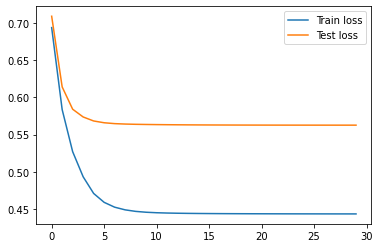

In [108]:
plt.plot(train_loss, label="Train loss")
plt.plot(test_loss, label="Test loss")
plt.legend()
plt.show()